In [89]:
import os
import SimpleITK as sitk
# ! pip install SimpleITK==1.2.4
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from ipywidgets import interact, fixed
from IPython.display import display
%matplotlib inline

### Helper functions (display / intensity) + DF

In [91]:
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    


def interactive_view(img):
    size = img.GetSize()
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)))
    
    
def label_overlay(img, seg):
    minmax = sitk.MinimumMaximumImageFilter()
    minmax.Execute(img)
    low, high = minmax.GetMinimum(), minmax.GetMaximum()
    img_norm = (img - low) / (high - low)
    img_uint8 = sitk.Cast(256 * img_norm, sitk.sitkUInt8)
    return sitk.LabelOverlay(img_uint8, seg)

def display_overlay(img, seg, *args, **kwargs):
    display_image(label_overlay(img, seg), *args, **kwargs)

In [95]:
# DATAFRAME HELPER
def _get_coords(single_test, start_x=0, start_y=0,start_z=0):
    # gets coords of ENDBPID
    x_diff= (single_test.centerlinelength*single_test.dircosx).values
    y_diff = (single_test.centerlinelength*single_test.dircosy).values
    z_diff = (single_test.centerlinelength*single_test.dircosz).values
    endbpid = single_test.endbpid.values
    startbpid = single_test.startbpid.values
    x = np.zeros_like(x_diff)
    y = np.zeros_like(x_diff)
    z = np.zeros_like(x_diff)
    for i in range(len(x_diff)):
        if startbpid[i] == -1:
            x[i] = x_diff[i] + start_x
            y[i] = y_diff[i] + start_y
            z[i] = z_diff[i] + start_z
        else:
            # find parent id
            parent = np.where(endbpid == startbpid[i])
            x[i] = x_diff[i] + x[parent] 
            y[i] = y_diff[i] + y[parent] 
            z[i] = z_diff[i] + z[parent] 
    # put into dataframe
    coords_df = pd.DataFrame({"x": x, "y": y, "z":z})
    
    return single_test.join(coords_df, how="left")


### Test data

In [78]:
aw_test = "/DATA/data_MESA/MESA_FL_Ex5_Nifty/AW/3010007_AW.nii.gz"
img_test = "/DATA/data_MESA/MESA_FL_Ex5_Nifty/IMG/3010007_IMG.nii.gz"
lung_test = "/DATA/data_MESA/MESA_FL_Ex5_Nifty/LUNG/3010007_LUNG.nii.gz"

In [79]:
aw_img = sitk.ReadImage(aw_test)
lung_img = sitk.ReadImage(lung_test)
img = sitk.ReadImage(img_test)

In [139]:
# get the tree data for this participant
df = pd.read_csv(os.path.abspath("/home/sneha/airway_exploration/e5_cleaned_v1.csv"))
tree = df.loc[df.idno == 3010007]
if 'radius' not in tree.columns:
    tree['radius'] = np.sqrt(tree.avginnerarea.copy()/np.pi)
    tree['radius'].fillna(0, inplace=True)
    tree['radius'] = tree.radius.astype(int)
display(tree)


/home/sneha/miniconda3/envs/my_env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_30138/846826031.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree['radius'] = np.sqrt(tree.avginnerarea.copy()/np.pi)
/tmp/ipykernel_30138/846826031.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree['radius'].fillna(0, inplace=True)
/tmp/ipykernel_30138/846826031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,radius
0,3010007,Trachea,104.962000,351.51300,0.0,0.0,1.0,-1.0,NaN,-0.024446,0.229788,0.972934,0,10
1,3010007,LMB,51.014200,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,0.045926,0.792214,1,6
2,3010007,RMB,25.444200,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,-0.047878,0.718164,1,8
3,3010007,BronInt,29.831900,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,0.018167,0.908341,2,5
4,3010007,RUL,16.649400,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,-0.038720,-0.580802,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,3010007,-,1.658150,-1.00000,5.0,18.0,377.0,354.0,101.6280,0.408248,0.816497,0.408248,12,0
377,3010007,-,14.326200,8.93574,5.0,19.0,379.0,360.0,167.6940,-0.260333,0.260333,0.929760,12,1
378,3010007,-,14.695600,6.03235,5.0,19.0,378.0,360.0,153.0900,-0.267261,0.801784,0.534522,12,1
379,3010007,-,0.865964,-1.00000,2.0,9.0,380.0,370.0,180.0000,0.000000,0.707107,0.707107,12,0


In [80]:
print(img)

Image (0x5563535d3d60)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 2613
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 2592
  UpdateMTime: 2612
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 670]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 670]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 670]
  Spacing: [1, 1, 1]
  Origin: [-1, -1, 1]
  Direction: 
-1 0 0
0 -1 0
0 0 1

  IndexToPointMatrix: 
-1 0 0
0 -1 0
0 0 1

  PointToIndexMatrix: 
-1 0 0
0 -1 0
0 0 1

  Inverse Direction: 
-1 0 0
0 -1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x556356c57e70)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count: 1
      Modified Time: 2609
      

In [126]:
print(img.GetSpacing(), img.GetSize())
# each voxel is 1mm, 1mm, 1mm size. The voxel grid is of size 512x512x670

(1.0, 1.0, 1.0) (512, 512, 670)


In [127]:
interactive_view(lung_img)
interactive_view(aw_img)
interactive_view(img)

# z = 0, x= 256, y = 256 on this image appears to be the top of the trachea
# --> can see this by scrolling down z axis from 0--> 670 on aw_img

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

### Single Slice

In [128]:
img_array =  sitk.GetArrayFromImage(aw_img)
size = img.GetSize()
spacing = img.GetSpacing()

width  = size[0] * spacing[0]
height = size[1] * spacing[1]
depth  = size[2] * spacing[2]

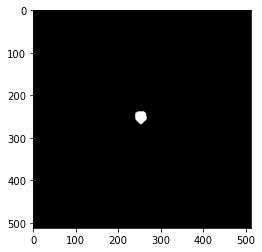

In [129]:
# top down
plt.imshow(img_array[1,:,:], cmap='gray', extent=(0, width, height, 0))

Text(0, 0.5, 'sum x,y')

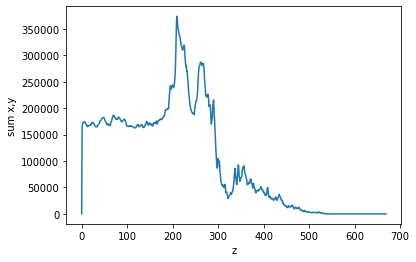

In [130]:
# sum each slice along + plot along z axis
plt.plot(np.arange(0, 670), img_array.sum(axis=(1,2)))
plt.xlabel('z')
plt.ylabel('sum x,y')

First non zero slice 1


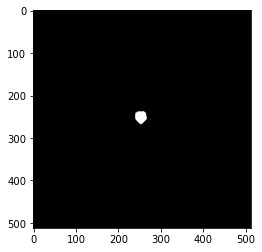

Circle (252, 251) 15


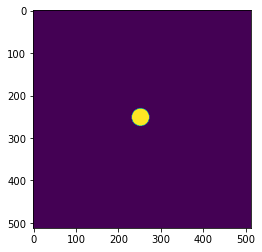

In [140]:
def find_start_point(aw_img):
    # function to find trachea
    # 1: find first slice with non zero pixels 
    # sum along z_axis
    img_array =  sitk.GetArrayFromImage(aw_img)
    size = img.GetSize()
    spacing = img.GetSpacing()

    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    z = img_array.sum(axis=(1,2))
    loc = np.argmax(z> 0) # index of first non-zero slice
    print("First non zero slice", loc)
    # get that slice and display it
    _slice = img_array[loc,:,:]
    cv2_img = _slice

    # top down
    plt.imshow(cv2_img, cmap='gray')
    plt.show()
    # find the contours
    contours, hierarchy = cv2.findContours(_slice, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    assert len(contours) == 1, f"Unexpected number of contours {len(contours)}"
    # Use a list to store the center and radius of the target circles:
    # cv2.imshow('Circles', _slice)
    # Look for the outer contours:
    for i, c in enumerate(contours):
        # Approximate the contour to a circle:
        (x, y), radius = cv2.minEnclosingCircle(c)
        # Compute the center and radius:
        center = (int(x), int(y))
        radius = int(radius)
        print("Circle",center,radius)
    #     # Draw the circles:
        cv2.circle(cv2_img, center, radius, (255, 0, 0), 10)
        plt.imshow(cv2_img)
    return center, loc
(startx, starty), startz = find_start_point(aw_img)

In [162]:
tree_w_coords = _get_coords(tree, start_x=startx, start_y=starty, start_z=startz)
tree_w_coords[['x', 'y', 'z']] = tree_w_coords[['x', 'y', 'z']].astype(int)
tree_w_coords

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,radius,x,y,z
0,3010007,Trachea,104.962000,351.51300,0.0,0.0,1.0,-1.0,NaN,-0.024446,0.229788,0.972934,0,10,249,275,103
1,3010007,LMB,51.014200,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,0.045926,0.792214,1,6,280,277,143
2,3010007,RMB,25.444200,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,-0.047878,0.718164,1,8,231,273,121
3,3010007,BronInt,29.831900,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,0.018167,0.908341,2,5,219,274,148
4,3010007,RUL,16.649400,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,-0.038720,-0.580802,2,4,218,273,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,3010007,-,1.658150,-1.00000,5.0,18.0,377.0,354.0,101.6280,0.408248,0.816497,0.408248,12,0,173,286,240
377,3010007,-,14.326200,8.93574,5.0,19.0,379.0,360.0,167.6940,-0.260333,0.260333,0.929760,12,1,200,313,270
378,3010007,-,14.695600,6.03235,5.0,19.0,378.0,360.0,153.0900,-0.267261,0.801784,0.534522,12,1,200,321,265
379,3010007,-,0.865964,-1.00000,2.0,9.0,380.0,370.0,180.0000,0.000000,0.707107,0.707107,12,0,306,306,257


[ 49  51  57  59  62  64  65  69  72  73  74  75  76  77  79  80  81  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 105 106 107 108 109 110 111 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 130 131 132 133 134 136 137 138 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 158 159 160 161 162 163 164
 165 166 167 168 170 171 172 173 174 175 176 178 179 180 181 182 183 184
 185 186 187 189 190 191 192 193 194 195 196 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 213 214 215 216 219 220 221 222 224 227 228
 229 230 231 233 235 236 238 240 241 242 243 244 246 251 252 253 254 255
 256 257 258 261 265 270 281]
143


,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,radius,x,y,z
1,3010007,LMB,51.0142,148.68100,0.0,0.0,3.0,1.0,140.036,0.608512,0.045926,0.792214,1,6,280,277,143
197,3010007,-,10.0241,4.43331,5.0,15.0,199.0,124.0,156.172,0.000000,0.851658,-0.524097,8,1,200,318,143


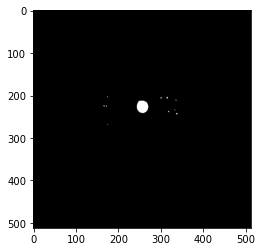

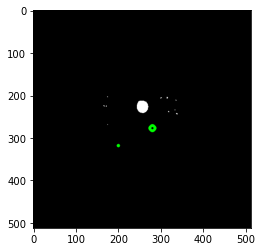

In [164]:
z_options, freq = np.unique(tree_w_coords.z.values, return_counts=True)
print(z_options)
z_ = 143
print(z_)
df_slice = tree_w_coords.loc[tree_w_coords.z==z_]
display(df_slice)
cv2_img = cv2.cvtColor(img_array[z_, :,:], cv2.COLOR_GRAY2RGB)
plt.imshow(cv2_img)
plt.show()
for i in range(len(df_slice)):
    center = (df_slice.iloc[i]['x'], df_slice.iloc[i]['y'])
    radius = int(df_slice.iloc[i]['radius'])
    cv2.circle(cv2_img, center, radius, (0, 255, 0), 5)

plt.imshow(cv2_img)


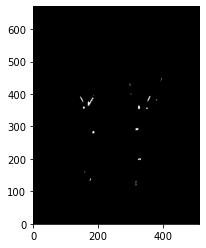

In [14]:
plt.imshow(img_array[:,200,:], origin='lower', cmap='gray', extent=(0, width, 0, depth))

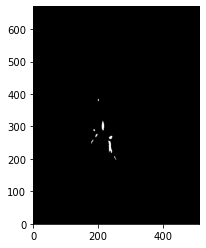

In [15]:
plt.imshow(img_array[:,:,180], origin='lower', cmap='gray', extent=(0, height, 0, depth))

(512, 512, 670)


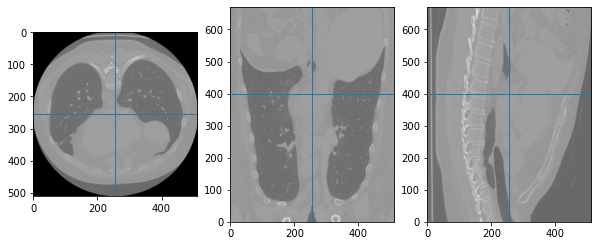

In [16]:
print(img.GetSize())
display_image(img, 256,256,400)

(array([1.7537307e+08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.6341000e+05]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <BarContainer object of 20 artists>)

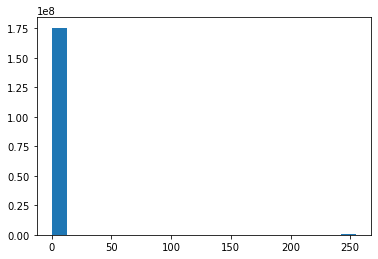

In [17]:
plt.hist(img_array.flatten(), bins=20, density=False)

In [28]:
seg_contour = sitk.LabelContour(img)

print("Thresholding - Surface")
display_image(label_overlay(seg_contour, lung))
interactive_view(seg_contour)

Thresholding - Surface


NameError: name 'lung' is not defined